In [12]:
#install/import the packages needed

#NOTE: this note book's performance is optmized when there is a GPU (cuda) available in the system.
!pip install csp
!pip install jsonlines
!pip install rapidfuzz
from jsonlines import InvalidLineError
import sys
import pandas as pd
import numpy as np
import csv
import transformers
import csp
import torch
from datetime import *
from csp.adapters.csv import *
from transformers import pipeline
import re
import ast
from rapidfuzz import fuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.5/32.5 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.0 MB/s eta 0:00:00


In [13]:
!gdown 1vi_darnK181xEnvONkkaJaP1-Npixf7B -O us_news_data.jsonl

Downloading...
From (original): https://drive.google.com/uc?id=1vi_darnK181xEnvONkkaJaP1-Npixf7B
From (redirected): https://drive.google.com/uc?id=1vi_darnK181xEnvONkkaJaP1-Npixf7B&confirm=t&uuid=54e0ebdb-e172-49a3-8a55-d39b1fc47d3b
To: /content/us_news_data.jsonl
100% 4.61G/4.61G [00:44<00:00, 104MB/s]


In [15]:
#these codes were used to pre-process the opoint news data.
#filter the data
#!gdown 1vi_darnK181xEnvONkkaJaP1-Npixf7B -O us_news_data.jsonl
'''
#we use only the use data from the opoint data source
i == 0
with jsonlines.open('drive/MyDrive/english_data.jsonl') as reader, jsonlines.open('drive/MyDrive/us_news_data.jsonl', mode='w') as writer:
    name_error_count = 0
    code_error_count = 0
    while True:
        i += 1  # Large number to ensure we can loop through the file
        try:
            obj = reader.read()  # Explicitly read each object
        except InvalidLineError as e:
            # Skip the invalid line and print a warning
            print(f"\nSkipping invalid line {i}: {e}")
            continue  # Skip to the next iteration
        except EOFError:
            # End of file, break the loop
            print('end of file')
            break

        # If object is valid, continue processing

        countryname = None
        countrycode = None
        try:
            countryname = obj['countryname']
        except KeyError as e:
            # Handle cases where 'language' or 'text' keys are missing
            print(f"\n Name KeyError in line {i + 1}: {e}")
        try:
            countrycode = obj['countrycode']
        except KeyError as e:
            print(f"\nCode KeyError in line {i + 1}: {e}")

        if countryname == "United States" or countrycode == "US":
            writer.write(obj)
            english_count += 1
            # Print the current count, overwrite the previous line
            sys.stdout.write(f"\rEnglish documents written: {english_count}")
            sys.stdout.flush()

        if countryname is None:
            name_error_count += 1
        if countrycode is None:
            code_error_count += 1

print('name key missing: %s'%name_error_count)
print('code key missing: %s'%code_error_count)

# Open the JSONL file and write to CSV
with jsonlines.open('drive/MyDrive/us_news_data.jsonl') as reader, open('output.csv', mode='w', newline='') as file:
    # Define the CSV writer
    writer = csv.writer(file)

    # Write the header row (adjust based on the fields you want)
    writer.writerow(['unix_timestamp', 'header', 'body_text', 'rank_country', 'domain',
       'article_readership', 'organization'])

    # Iterate over the JSONL file and write specific fields to CSV
    for i, obj in enumerate(reader):
        # Extract the fields you're interested in
        row = [obj.get('unix_timestamp'), obj.get('header'), obj.get('body',{}).get('text'),
               obj.get('site_rank',{}).get('rank_country'),
               obj.get('similarweb',{}).get('domain'),
               obj.get('similarweb',{}).get('article_readership'),
               obj.get('topics_and_entities',{}).get('entities',{}).get('organization')]
        writer.writerow(row)

#data code
df = pd.read_csv("drive/MyDrive/us_news_data.csv", delimiter = '\t')
df.iloc[::-1].reset_index(drop = True).to_csv("drive/MyDrive/us_news_data.csv", sep = '\t', index = False)
'''


'\n#we use only the use data from the opoint data source\ni == 0\nwith jsonlines.open(\'drive/MyDrive/english_data.jsonl\') as reader, jsonlines.open(\'drive/MyDrive/us_news_data.jsonl\', mode=\'w\') as writer:\n    name_error_count = 0\n    code_error_count = 0\n    while True:\n        i += 1  # Large number to ensure we can loop through the file\n        try:\n            obj = reader.read()  # Explicitly read each object\n        except InvalidLineError as e:\n            # Skip the invalid line and print a warning\n            print(f"\nSkipping invalid line {i}: {e}")\n            continue  # Skip to the next iteration\n        except EOFError:\n            # End of file, break the loop\n            print(\'end of file\')\n            break\n\n        # If object is valid, continue processing\n\n        countryname = None\n        countrycode = None\n        try:\n            countryname = obj[\'countryname\']\n        except KeyError as e:\n            # Handle cases where \'lan

In [16]:

#a csp node defined to filter the news based on a list of patterns (common expressions)
#it only tick if there is a match for the common expression in the header

@csp.node
def filter_news(article: {str : ts[str]}, organization:ts[list],rank_threshold: int, patterns: list) -> csp.Outputs(header = ts[str], domain = ts[str], organization = ts[list]):

  if csp.ticked(article):
    if article['rank_country'] != "" and float(article['rank_country']) <= rank_threshold:
      matched = False
      for pattern in patterns:
        if re.search(pattern, article['header']):
          matched = True

      if matched:
        try:
          orgs = ast.literal_eval("".join(organization))
        except Exception as e:
          orgs = []

        return csp.output(header = article['header'], domain = article['domain'], organization = orgs)

In [17]:
#define a LLM node that conduct name entity recognition
#whenever header tick, it searches the header for entity and then return the list of entities found

@csp.node
def NER(header: ts[str], model: str ) -> ts[list]:
  with csp.start():
    ner_model = transformers.pipeline("ner", model=model, device = 'cuda' if torch.cuda.is_available() else 'cpu')


  if csp.ticked(header):
    ner_output = ner_model(header)

    #because bert model use separate token methodology to do entity recognition, so we need
    #to recombined the token to form the entity words
    combined_entities = []
    current_entity = ""
    current_label = ""
    previous_index = None  # To track the position of the last token

    for token in ner_output:
        word = token['word']
        entity_label = token['entity']
        index = token['index']

        # Only process tokens that are part of an organization (ORG)
        if 'ORG' not in entity_label:
            continue

        # If this is a new entity (either by index gap or different label), save the previous one
        if previous_index is not None and (entity_label != current_label or index != previous_index + 1):
            combined_entities.append(current_entity)
            current_entity = ""

        # Append current token to the entity
        if current_entity == "":
            # Start a new entity
            current_entity = word if not word.startswith("##") else word[2:]
        else:
            # Continuation of the current entity
            if word.startswith("##"):
                current_entity += word[2:]
            else:
                current_entity += " " + word

        # Update the current label and index
        current_label = entity_label
        previous_index = index

    # Add the last entity to the list
    if current_entity:
        combined_entities.append(current_entity)

    return combined_entities



In [18]:
#sentiment analysis
#conduct sentiment analysis to the header using finbert whenever header ticked
@csp.node
def entity_sentiments(sentence:ts[str], model:str) -> ts[int]:
  with csp.start():
    sentiment_model = transformers.pipeline("sentiment-analysis", model = model, device = 'cuda' if torch.cuda.is_available() else 'cpu')
    map = {'positive':1, 'neutral':0, 'negative':-1}


  if csp.ticked(sentence):
    return map[sentiment_model(sentence)[0]['label']]


In [19]:
#make real time investment decision based on recognized entities and labeled sentiment
#return a dictionary of portfolio, where key is the ticker of the equity and value is the integer for positon
@csp.node
def managed_news_portfolio(entities:ts[list], sentiment:ts[int], company_dicts:dict) -> ts[dict]:
  #set an alarm for closing the positon
  with csp.alarms():
    alarm = csp.alarm(list)

  #initialize the portfolio
  with csp.start():
    portfolio = {val:0 for val in company_dicts.values()}


  #match the entities:
  #we increase/decrease 100$ for the news
  #we hold the position for one hour
  for entity in entities:
    if entity.lower() in company_dicts:
      portfolio[company_dicts[entity.lower()]] += sentiment * 100
      csp.schedule_alarm(alarm, timedelta(hours = 1), [company_dicts[entity.lower()] , -sentiment])

  #after one hour we close the previous position
  if csp.ticked(alarm):
    ticker, neg_sentiment = alarm[0], alarm[1]
    portfolio[ticker] += neg_sentiment * 100

  return portfolio

In [20]:
#define a output node to write the snap shot of portfolio in time into a csv file for the evaluation graph
#for the sake of this competition we record the state of portfolio every minute and evaluate them against price data
@csp.node
def csv_output(portfolio:ts[dict],times: ts[datetime], companies_tickers_dict:dict, filename: str):
  with csp.start():
    file = open(filename, mode='w', newline='')
    fieldnames = ['timestamp'] + list(companies_tickers_dict.values())
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()

  with csp.stop():
    file.close()


  if csp.ticked(portfolio):
    portfolio['timestamp'] = times
    writer.writerow(portfolio)


In [21]:
#the actual running code
class article(csp.Struct):
  header:str
  rank_country:str
  domain:str
  organization:list

# Increase the CSV field size limit to handle larger fields
csv.field_size_limit(sys.maxsize)

def time_converter(column, tz=None):
    def convert(row):
        v = row[column]
        dt = datetime.utcfromtimestamp(int(v)).replace(tzinfo = None)
        if tz is not None:
            dt = tz.localize(dt)
        return dt

    return convert


@csp.graph
def LLM_graph(news_data_path:str, patterns:list, model_ner:str, model_senti:str, company_dicts: dict, out_filename:str) -> ts[dict]:
  #get the news data
  reader = CSVReader(news_data_path, time_converter('unix_timestamp'), delimiter = '\t')
  data = reader.subscribe_all(article)

  #use a timer to record portfolio in every minute
  timer = csp.timer(interval = timedelta(minutes = 1), value = True, allow_deviation=False)

  #filter news article
  filtered_output = filter_news({'header': data.header,
                                 "rank_country": data.rank_country,
                                 "domain": data.domain},data.organization,40,patterns)
  filtered_header = filtered_output.header

  #perform entities recognition and sentiment analysis
  entities = NER(filtered_header, model_ner)
  sentiments = entity_sentiments(filtered_header, model_senti)

  #form the portfolio and record it
  portfolios = csp.sample(trigger = timer,x = managed_news_portfolio(entities, sentiments, company_dicts))
  csv_output(portfolios, csp.times(portfolios), company_dicts,out_filename)




In [22]:
#download the preprocessed news data in csv
!gdown 1f37pWrsbgwx6JLv9Z3FBvTQtxOk4o-fa -O us_news_data.csv

Downloading...
From (original): https://drive.google.com/uc?id=1f37pWrsbgwx6JLv9Z3FBvTQtxOk4o-fa
From (redirected): https://drive.google.com/uc?id=1f37pWrsbgwx6JLv9Z3FBvTQtxOk4o-fa&confirm=t&uuid=54fad80a-1404-4fbe-b2f6-201c20070026
To: /content/us_news_data.csv
100% 2.27G/2.27G [00:17<00:00, 132MB/s]


In [23]:

#a list of patterns/common expressions found in common finance related news article headers
patterns = [
    r"^Earnings call",
    r"\b(Earnings report|Q[1-4] Earnings|Results)\b",
    r"\b(dividend|special dividend|declares dividend|stock buyback)\b",
    r"\b(stock split|reverse stock split)\b",
    r"\b(IPO|Initial Public Offering)\b",
    r"\b(merger|acquisition|M&A|to acquire|deal)\b",
    r"\b(upgrade|downgrade|raises rating|lowers rating)\b",
    r"\b(guidance|raises forecast|lowers forecast|outlook)\b",
    r"\b(CEO|chief executive|appoints new CEO|steps down|resignation)\b",
    r"\b(layoffs|hiring freeze|job cuts|restructuring)\b",
    r"\b(product launch|expansion|introduces|unveils)\b",
    r"\b(SEC investigation|probe|investigation)\b",
    r"\b(lawsuit|settlement|court case|suit filed)\b",
    r"\b(interest rate|rate hike|rate cut|Federal Reserve)\b",
    r"\b(inflation report|consumer prices|CPI|inflation rise)\b",
    r"\b(GDP growth|recession fears|economic slowdown)\b",
    r"\b(hits all-time high|hits all-time low|plunges|soars|jumps)\b",
    r"\b(debt issuance|bond offering|raises debt|issues bonds)\b",
    r"\b(credit rating|downgraded to|upgraded)\b",
    r"\b(oil prices|gold prices|commodity prices)\b",
    r"\b(dollar strengthens|dollar weakens|currency movement)\b",
    r"\b(trade war|tariffs|sanctions)\b",
    ]

#a list of common companies found in the news
companies_with_tickers = [
    ("Apple", "AAPL"),
    ("Tesla", "TSLA"),
    ("Sanofi", "SNY"),
    ("Wells Fargo", "WFC"),
    ("Intel", "INTC"),
    ("UBS", "UBS"),
    ("Boeing", "BA"),
    ("Campari", "CPR.MI"),
    ("VMware", "VMW"),
    ("Barclays", "BCS"),
    ("Nikon", "7731.T"),
    ("Tata Motors", "TTM"),
    ("Home Depot", "HD"),
    ("Finning International Inc", "FTT.TO"),
    ("Novavax", "NVAX"),
    ("Aker", "AKER.OL"),
    ("Arkema", "AKE.PA"),
    ("Securitas", "SECUB.ST"),
    ("LANXESS", "LXS.F"),
    ("Crombie REIT", "CRR.UN.TO"),
    ("Terna", "TRN.MI"),
    ("SBI Holdings", "8473.T"),
    ("Paycor", "PYCR"),
    ("Continental AG", "CON.DE"),
    ("Amerigo Resources", "ARG.TO"),
    ("Kinaxis Inc", "KXS.TO"),
    ("Loomis", "LOOMIS.ST"),
    ("Cineplex", "CGX.TO"),
    ("Dundee Precious Metals", "DPM.TO"),
    ("Leonardo", "LDO.MI"),
    ("AvidXchange", "AVDX"),
    ("Black Rifle Coffee", "BRCC"),
    ("Savaria Corporation", "SIS.TO"),
    ("InnovAge", "INNV"),
    ("Altus Power", "AMPS"),
    ("ZipRecruiter", "ZIP"),
    ("Sangoma", "STC.V"),
    ("Five9", "FIVN"),
    ("Equinix", "EQIX"),
    ("Lesaka Technologies", "LSAK"),
    ("Kelly Services", "KELYB"),
    ("Crane NXT", "CXT"),
    ("ProAssurance", "PRA"),
    ("Standard BioTools", "LAB"),
    ("PLDT", "PHI"),
    ("Mirum Pharmaceuticals", "MIRM"),
    ("Wheaton Precious Metals", "WPM"),
    ("First Advantage", "FA"),
]

companies_tickers_dict = {com[0].lower():com[1] for com in companies_with_tickers}
out_filename = "portfolio_positions.csv"

news_data_path = "us_news_data.csv"

#2 model, one for NER, one for sentiment analysis
model_ner= "dbmdz/bert-large-cased-finetuned-conll03-english"
model_senti = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"

csp.run(LLM_graph,news_data_path, patterns , model_ner, model_senti,companies_tickers_dict, out_filename, starttime = datetime.utcfromtimestamp(1715587200), endtime = timedelta(hours = 14))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [24]:
#benchmark strategies

#this node extract the entity name and sentiment info from the dataset
#and then subsetquently pass to the portfolio builder
@csp.node
def entities_sentiment_getter(organizations:ts[list], company_dicts:dict, threshold:int) -> csp.Outputs(entities = ts[list], sentiment = ts[int]):
  entities = []
  sentiment = 0
  for d in organizations:

    entity = d.get('entity',None)
    senti = d.get('sentiment',None)

    if entity == None or senti == None:
      continue


    matched_company = None
    for company in company_dicts:
      similarity = fuzz.partial_ratio(company, entity.lower())
      if similarity >= threshold:
        matched_company = company

    if matched_company:
      entities.append(matched_company)

    if senti == 'Positive':
      sentiment += 1
    elif senti == 'Negative':
      sentiment -= 1

    #normalize the sentiment
    if sentiment > 0:
      sentiment = 1
    elif sentiment < 0:
      sentiment = -1
  return csp.output(entities = entities, sentiment = sentiment)


In [25]:
#pretty much the same as the previous graph, but output csv for the benchmark strategies.
class article(csp.Struct):
  header:str
  rank_country:str
  domain:str
  organization:list


def time_converter(column, tz=None):
    def convert(row):
        v = row[column]
        dt = datetime.utcfromtimestamp(int(v)).replace(tzinfo = None)
        if tz is not None:
            dt = tz.localize(dt)
        return dt

    return convert


@csp.graph
def labeled_graph(news_data_path:str, patterns:list, company_dicts: dict,threshold:int ,out_filename:str) -> ts[dict]:
  reader = CSVReader(news_data_path, time_converter('unix_timestamp'), delimiter = '\t')
  data = reader.subscribe_all(article)
  timer = csp.timer(interval = timedelta(minutes = 1), value = True, allow_deviation=False)

  filtered_output = filter_news({'header': data.header,
                                 "rank_country": data.rank_country,
                                 "domain": data.domain},data.organization,40,patterns)
  filtered_header = filtered_output.header

  entity_sentiments =  entities_sentiment_getter(filtered_output.organization, company_dicts, threshold)
  entities = entity_sentiments.entities
  sentiments = entity_sentiments.sentiment

  portfolios = csp.sample(trigger = timer,x = managed_news_portfolio(entities, sentiments, company_dicts))

  csv_output(portfolios, csp.times(portfolios), company_dicts,out_filename)

threshold = 90
out_filename = "benchmark_news_portfolio.csv"
csp.run(labeled_graph, news_data_path,patterns,companies_tickers_dict, threshold ,out_filename, starttime = datetime.utcfromtimestamp(1715587200), endtime = timedelta(hours = 14))

## Performance Metrics

### Import Preprocessed results data

In [32]:
# Download the files using gdown
!gdown "https://drive.google.com/uc?id=1IpA_TudhtYPX5wD-QOBViCaX0GSv8Kur" # Minute level Preprocessed Asset price data from Databento
!gdown "https://drive.google.com/uc?id=1sJXWmmWwCfZRmJx5CmLAYDPcmc6P5V9z" # Our model allocation data
!gdown "https://drive.google.com/uc?id=1UE2beEPr6oZV9DY3XsjvCtg-cp3sHBWA"  # Benchmark Portfolio

Downloading...
From: https://drive.google.com/uc?id=1IpA_TudhtYPX5wD-QOBViCaX0GSv8Kur
To: /content/price_data.csv
100% 44.5k/44.5k [00:00<00:00, 58.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1sJXWmmWwCfZRmJx5CmLAYDPcmc6P5V9z
To: /content/portfolio_positions.csv
100% 21.1k/21.1k [00:00<00:00, 39.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UE2beEPr6oZV9DY3XsjvCtg-cp3sHBWA
To: /content/benchmark_news_portfolio.csv
100% 28.5k/28.5k [00:00<00:00, 45.5MB/s]


<ipython-input-37-10504c418758>:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '36917.33333333333' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  merged_df.at[i, f'{stock} Invested'] = prev_row[f'{stock} Invested'] * (row[f'{stock}_x'] / prev_row[f'{stock}_x'])
<ipython-input-37-10504c418758>:64: RuntimeWarning: divide by zero encountered in scalar divide
  merged_df.at[i, f'{stock} Invested'] = prev_row[f'{stock} Invested'] * (row[f'{stock}_x'] / prev_row[f'{stock}_x'])
<ipython-input-37-10504c418758>:64: RuntimeWarning: invalid value encountered in scalar multiply
  merged_df.at[i, f'{stock} Invested'] = prev_row[f'{stock} Invested'] * (row[f'{stock}_x'] / prev_row[f'{stock}_x'])
<ipython-input-37-10504c418758>:68: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '181204.5' has dtype incompatible with i

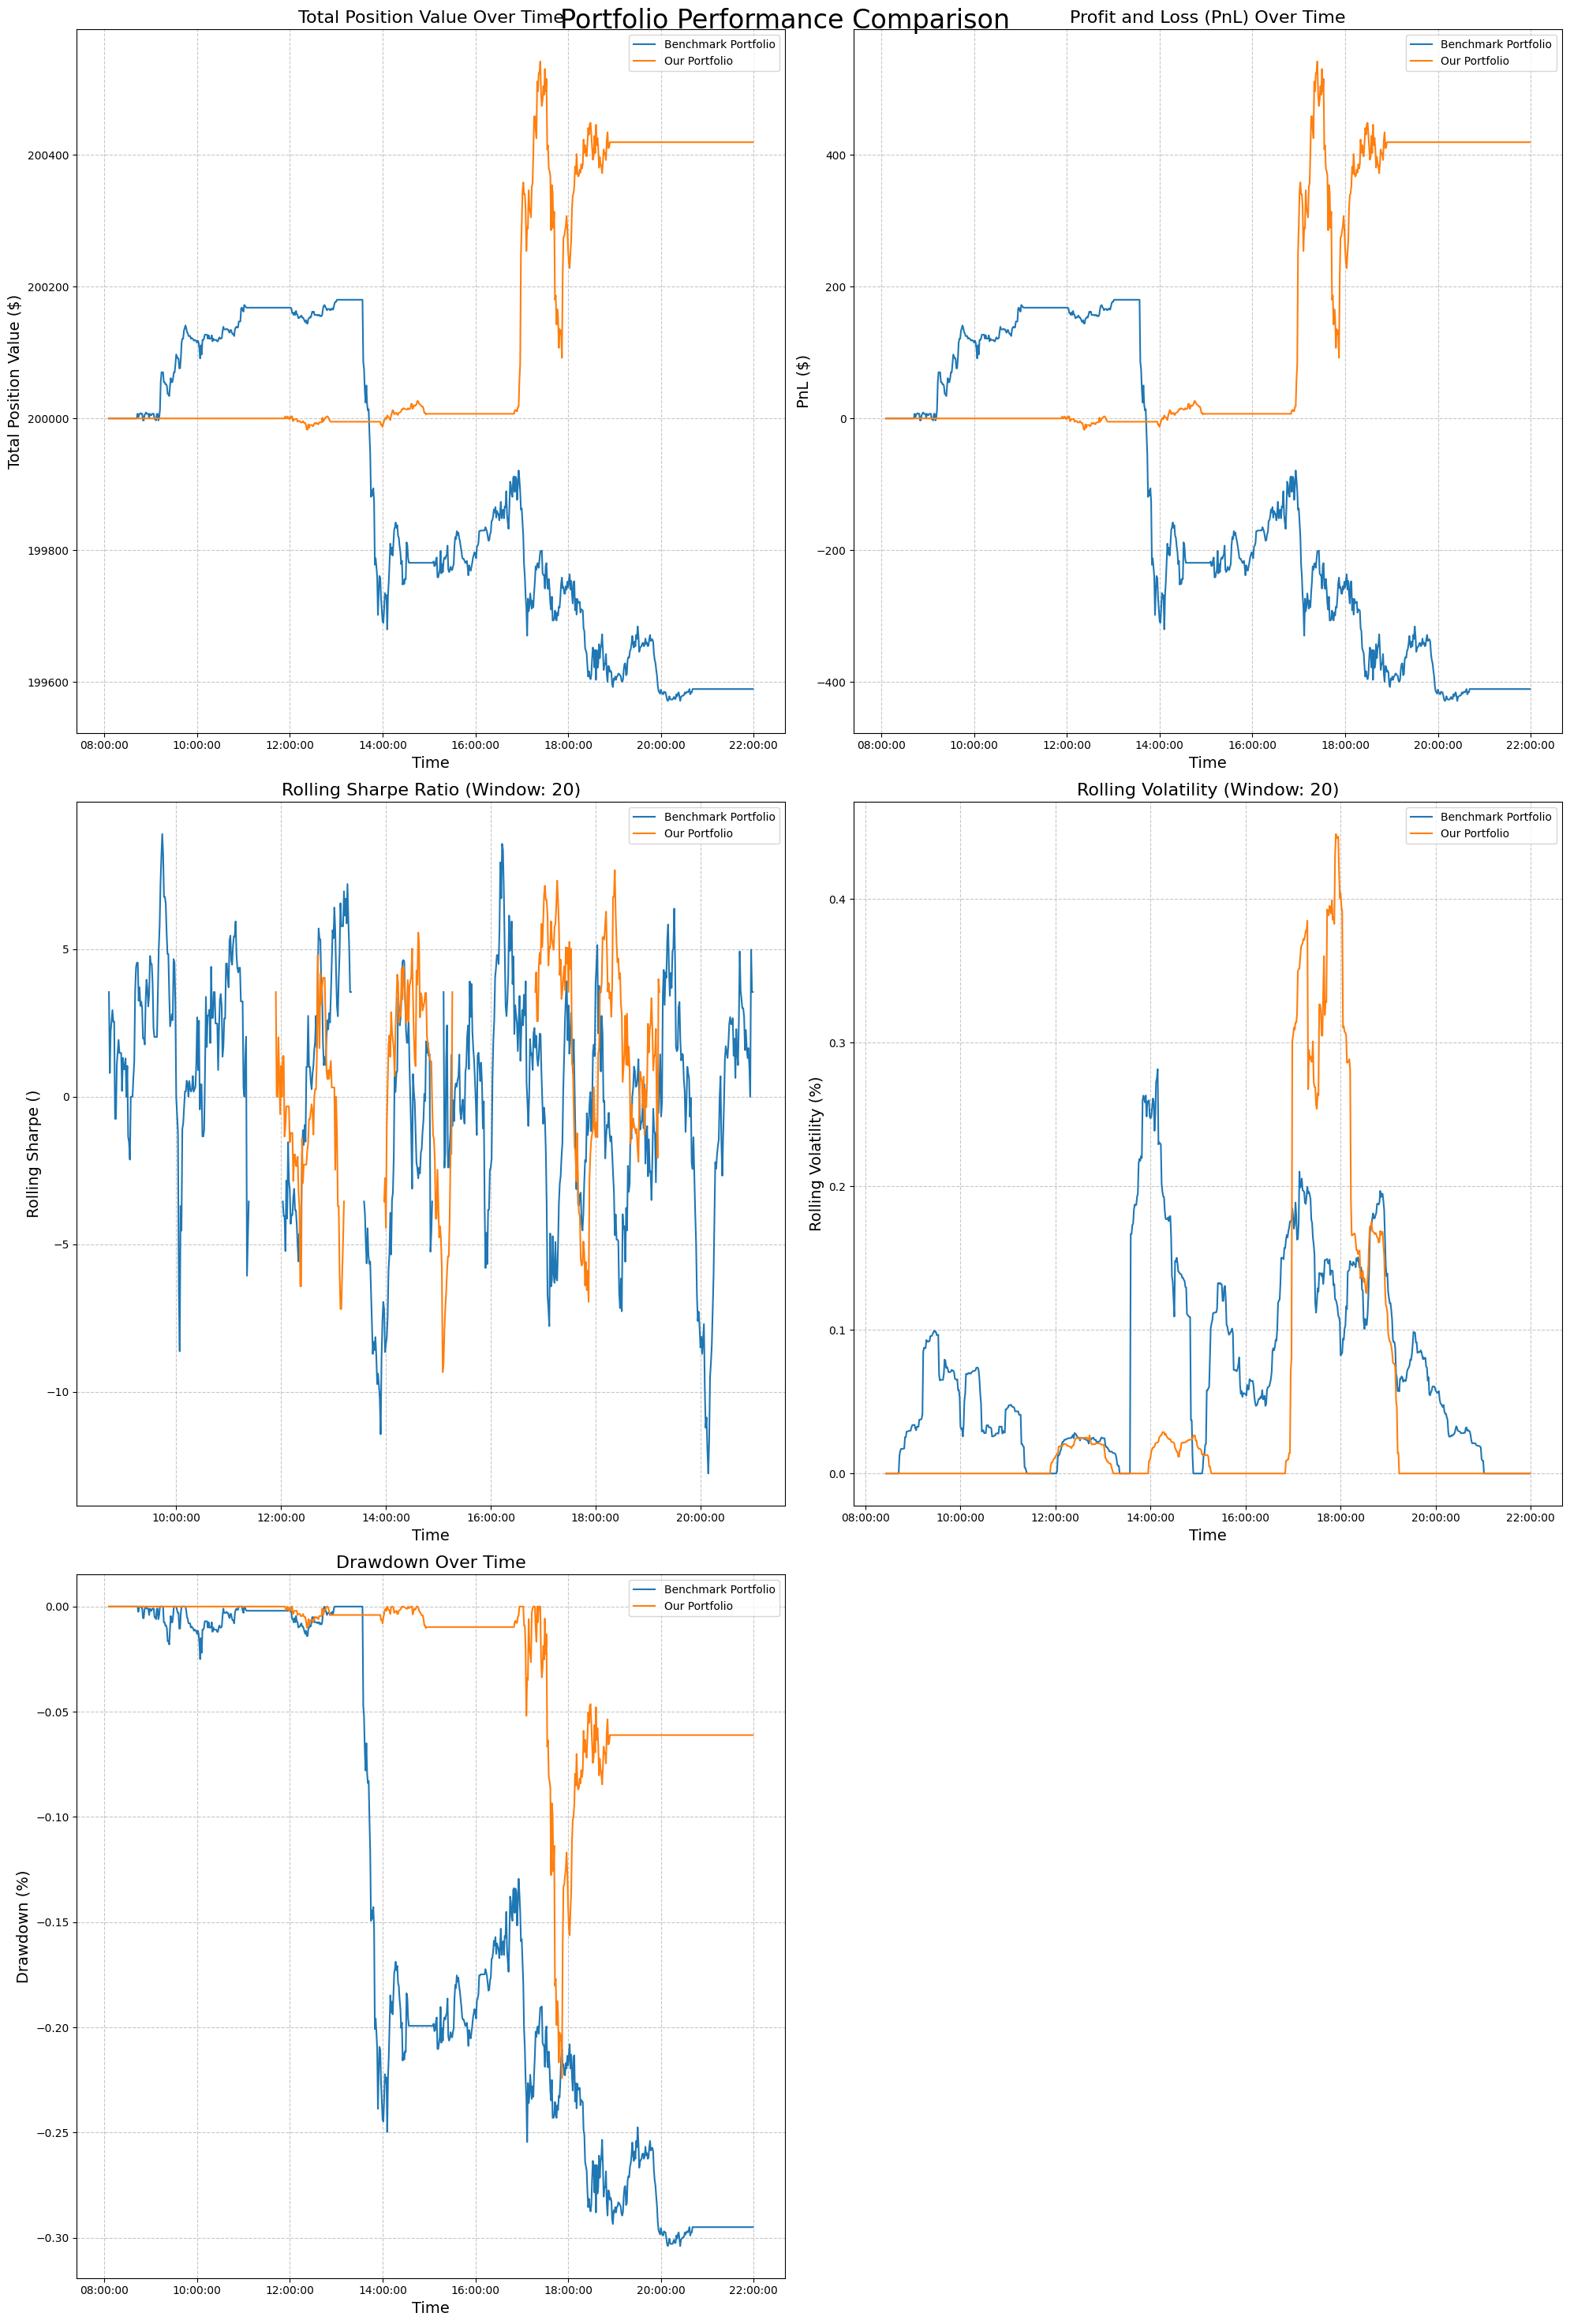


Benchmark Portfolio Summary:
Starting Balance: $200,000.00
Ending Balance: $199,589.50
Total Profit/Loss: $-410.50
Total Return: -0.21%
Final Sharpe Ratio: 0.16
Average Volatility: 0.09%
Max Drawdown: -0.30%

Our Portfolio Summary:
Starting Balance: $200,000.00
Ending Balance: $200,419.00
Total Profit/Loss: $419.00
Total Return: 0.21%
Final Sharpe Ratio: 0.84
Average Volatility: 0.12%
Max Drawdown: -0.22%


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load the stocks data
stocks_df = pd.read_csv("price_data.csv")

# Load the portfolio positions data
benchmark_df = pd.read_csv("benchmark_news_portfolio.csv")
our_portfolio_df = pd.read_csv("portfolio_positions.csv")

# Convert 'timestamp' to datetime format for stocks_df and our_portfolio_df
stocks_df['timestamp'] = pd.to_datetime(stocks_df['timestamp'], format='%H:%M:%S', errors='coerce')
our_portfolio_df['timestamp'] = pd.to_datetime(our_portfolio_df['timestamp'], format='%H:%M:%S', errors='coerce')

# Convert benchmark_df timestamp to match the format of stocks_df
benchmark_df['timestamp'] = pd.to_datetime(benchmark_df['timestamp'], format='%d-%m-%Y %H:%M', errors='coerce')
benchmark_df['timestamp'] = benchmark_df['timestamp'].dt.strftime('%H:%M:%S')
benchmark_df['timestamp'] = pd.to_datetime(benchmark_df['timestamp'], format='%H:%M:%S', errors='coerce')

# Check for conversion errors and drop rows with NaT values
for df_name, df in [("stocks", stocks_df), ("benchmark", benchmark_df), ("our portfolio", our_portfolio_df)]:
    if df['timestamp'].isnull().any():
        print(f"Warning: Some timestamps could not be converted in the {df_name} DataFrame. Dropping rows with NaT values.")
        df.dropna(subset=['timestamp'], inplace=True)

# Handle duplicates (average stock prices)
stocks_df = stocks_df.groupby('timestamp').mean().reset_index()
stocks_df.fillna(0, inplace=True)

# Merge the DataFrames on 'timestamp'
merged_benchmark = pd.merge(benchmark_df, stocks_df, on='timestamp', how='inner')
merged_our_portfolio = pd.merge(our_portfolio_df, stocks_df, on='timestamp', how='inner')

# Function to calculate portfolio metrics
def calculate_portfolio_metrics(merged_df, starting_balance=200000):
    stocks = ['AAPL', 'TSLA', 'INTC', 'NVAX', 'FIVN', 'EQIX', 'MIRM']

    merged_df['Cash Balance'] = starting_balance
    merged_df['Total Position Value'] = starting_balance

    for stock in stocks:
        merged_df[f'{stock} Invested'] = 0

    for i, row in merged_df.iterrows():
        if i == 0:
            continue

        prev_row = merged_df.iloc[i-1]
        cash_balance = prev_row['Cash Balance']

        for stock in stocks:
            position_change = row[f'{stock}_x'] - prev_row[f'{stock}_x']
            stock_price = row[f'{stock}_y']

            if position_change > 0:  # Buying
                money_spent = position_change * stock_price
                cash_balance -= money_spent
                merged_df.at[i, f'{stock} Invested'] = prev_row[f'{stock} Invested'] + money_spent
            elif position_change < 0:  # Selling
                money_received = -position_change * stock_price
                cash_balance += money_received
                merged_df.at[i, f'{stock} Invested'] = prev_row[f'{stock} Invested'] * (row[f'{stock}_x'] / prev_row[f'{stock}_x'])
            else:
                merged_df.at[i, f'{stock} Invested'] = prev_row[f'{stock} Invested']

        merged_df.at[i, 'Cash Balance'] = cash_balance

    for i, row in merged_df.iterrows():
        total_value = row['Cash Balance']
        for stock in stocks:
            total_value += row[f'{stock}_x'] * row[f'{stock}_y']
        merged_df.at[i, 'Total Position Value'] = total_value

    merged_df['PnL'] = merged_df['Total Position Value'] - starting_balance
    merged_df['Returns'] = merged_df['Total Position Value'].pct_change()

    window = 20
    merged_df['Rolling Volatility'] = merged_df['Returns'].rolling(window=window).std() * np.sqrt(252) * 100
    merged_df['Rolling Sharpe'] = (merged_df['Returns'].rolling(window=window).mean() * 252) / (merged_df['Rolling Volatility'] / 100)
    merged_df['Drawdown'] = ((merged_df['Total Position Value'] / merged_df['Total Position Value'].cummax()) - 1) * 100

    return merged_df

# Calculate metrics for both portfolios
benchmark_metrics = calculate_portfolio_metrics(merged_benchmark)
our_portfolio_metrics = calculate_portfolio_metrics(merged_our_portfolio)

# Create comparative plots
plot_titles = [
    'Total Position Value Over Time',
    'Profit and Loss (PnL) Over Time',
    'Rolling Sharpe Ratio (Window: 20)',
    'Rolling Volatility (Window: 20)',
    'Drawdown Over Time'
]

plot_data = [
    ('Total Position Value', '$'),
    ('PnL', '$'),
    ('Rolling Sharpe', ''),
    ('Rolling Volatility', '%'),
    ('Drawdown', '%')
]

# Create a 3x2 grid of subplots
fig, axs = plt.subplots(3, 2, figsize=(20, 30))
fig.suptitle('Portfolio Performance Comparison', fontsize=24)

for i, (title, (column, unit)) in enumerate(zip(plot_titles, plot_data)):
    row = i // 2
    col = i % 2
    ax = axs[row, col]

    ax.plot(benchmark_metrics['timestamp'], benchmark_metrics[column], label='Benchmark Portfolio', color='#1f77b4')
    ax.plot(our_portfolio_metrics['timestamp'], our_portfolio_metrics[column], label='Our Portfolio', color='#ff7f0e')
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Time', fontsize=14)
    ax.set_ylabel(f'{column} ({unit})', fontsize=14)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend()

# Remove the empty subplot
fig.delaxes(axs[2, 1])

plt.tight_layout()
plt.show()

# Print summary statistics
def print_portfolio_summary(metrics, name):
    print(f"\n{name} Portfolio Summary:")
    print(f"Starting Balance: ${200000:,.2f}")
    print(f"Ending Balance: ${metrics['Total Position Value'].iloc[-1]:,.2f}")
    print(f"Total Profit/Loss: ${metrics['PnL'].iloc[-1]:,.2f}")

    cumulative_returns = (metrics['Total Position Value'].iloc[-1] - 200000) / 200000
    final_sharpe_ratio = metrics['Rolling Sharpe'].replace(0, np.nan).dropna().mean()
    average_volatility = metrics['Rolling Volatility'].replace(0, np.nan).dropna().mean()
    max_drawdown = metrics['Drawdown'].min()

    print(f"Total Return: {cumulative_returns:.2%}")
    print(f"Final Sharpe Ratio: {final_sharpe_ratio:.2f}")
    print(f"Average Volatility: {average_volatility:.2f}%")
    print(f"Max Drawdown: {max_drawdown:.2f}%")

print_portfolio_summary(benchmark_metrics, "Benchmark")
print_portfolio_summary(our_portfolio_metrics, "Our")